# An item-based collaborative filtering

In [498]:
import requests
import bs4 as bs
from bs4 import BeautifulSoup
from requests_futures.sessions import FuturesSession
from urllib.parse import quote
from retrying import retry
from ediblepickle import checkpoint
import dill 
import pandas as pd
import os
import collections
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import glob
from collections import defaultdict
import time
import seaborn as sns

# getting the title of the top 1000 anime on myanimelist

In [2]:
#getting the first 21 pages of myanimelist each page includes links to 50 anime
address = 'https://myanimelist.net/topanime.php'
num_anime = list(range(0,1050,50))


cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
    
@checkpoint(key=lambda args, kwargs: str(args[0]), work_dir=cache_dir) 
@retry(wait_fixed = 5)
def get_main_pages_responses(param):
    session = FuturesSession(max_workers=3)
    main_pages_responses = [future.result() for future in 
                           [session.get(address, params={'limit':param})]]
    return main_pages_responses

all_main_pages = [get_main_pages_responses(page) for page in num_anime]

In [22]:
#how to get the link for each anime in a page
BeautifulSoup(all_main_pages[0][0].text).select('h3.hoverinfo_trigger.fl-l.fs14 a')[0]['href']

'https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood'

In [23]:
#getting links to all anime in the first 21 pages
def get_links(list_of_responses):
    soups = [BeautifulSoup(i.text) for pag in list_of_responses for i in pag]
    links = [i['href'] for soup in [soup.select('h3.hoverinfo_trigger.fl-l.fs14 a') for soup in soups] for i in soup ]
    return links

In [24]:
#links to all top 1000 anime 
links = get_links(all_main_pages)
links[-5:]

['https://myanimelist.net/anime/283/Akage_no_Anne',
 'https://myanimelist.net/anime/39619/BanG_Dream_Film_Live',
 'https://myanimelist.net/anime/740/Bishoujo_Senshi_Sailor_Moon_R',
 'https://myanimelist.net/anime/43683/Boku_no_Hero_Academia_the_Movie_2__Heroes_Rising_-_Epilogue_Plus_-_Yume_wo_Genjitsu_ni',
 'https://myanimelist.net/anime/1689/Byousoku_5_Centimeter']

In [83]:
#getting the anime id from the link
'https://myanimelist.net/anime/1689/Byousoku_5_Centimeter'.split('/')[-2:-1]

['1689']

# collecting anime info (statistics, director, producer, music ...) using Jikan API

In [467]:
# getting information such as statistics, director and else from https://jikan.moe/ API using anime id
def get_anime_info(anime_id):
    time.sleep(4)
    anime_info_dict = defaultdict(str)
    anime_info_dict['id'] = anime_id
    #requesting and adding staff information
    staff_info = requests.get(f'https://api.jikan.moe/v3/anime/{anime_id}/characters_staff/')
    pos_dict = defaultdict(str)
    for i in json.loads(staff_info.text)['staff']:
        for pos in i['positions']:
            pos_dict[pos] = i['name']
    anime_info_dict.update(pos_dict)
    
#     reviews = requests.get(f'https://api.jikan.moe/v3/anime/{anime_id}/reviews/')
    #requesting and adding statistics information
    stats = requests.get(f'https://api.jikan.moe/v3/anime/{anime_id}/stats/')
    for key in ['watching','completed','on_hold','dropped','plan_to_watch']:
        try:
            anime_info_dict[key] = json.loads(stats.text)[key]
        except:
             anime_info_dict[key] = None
    
    #requesting and adding general information
    general_info = requests.get('https://api.jikan.moe/v3/anime/39619')
    for key in ['source', 'episodes', 'duration', 'rating', 'rank', 'favorites', 'type']:
        try:
            anime_info_dict[key] = json.loads(general_info.text)[key]
        except:
            anime_info_dict[key] = None
        
    return anime_info_dict
    

In [468]:
#collecting the anime related data for all anime 
all_anime_info = defaultdict(str)
def get_all_anime_info(links):
    counter = 0 
    for link in links:
        counter+=1
        anime_name = link.split('/')[-1]
        anime_id = link.split('/')[-2:-1][0]
        all_anime_info[anime_name] = get_anime_info(anime_id)
        print(f'\rTrying anime {counter} of {len(links)}.', end='')
    return all_anime_info
get_all_anime_info(links)

Trying anime 1050 of 1050.

defaultdict(str,
            {'Fullmetal_Alchemist__Brotherhood': defaultdict(str,
                         {'id': '5114',
                          'Producer': 'Cook, Justin',
                          'Director': 'Irie, Yasuhiro',
                          'Episode Director': 'Yabuki, Tsutomu',
                          'Storyboard': 'Tomisawa, Nobuo',
                          'Sound Director': 'Mima, Masafumi',
                          '2nd Key Animation': 'Yoshioka, Takeshi',
                          'Key Animation': 'ryo-timo',
                          'Character Design': 'Kanno, Hiroki',
                          'Script': 'Tsuchiya, Michihiro',
                          'Series Composition': 'Oonogi, Hiroshi',
                          'Theme Song Lyrics': 'Yui',
                          'Theme Song Performance': 'Yui',
                          'Theme Song Arrangement': 'Sukima Switch',
                          'Theme Song Composition': 'Yui',
                          'A

In [482]:
#saving the anime info 
# with open('anime_features', 'wb') as f:
#     dill.dump(all_anime_info, f)


In [487]:
#reading anime info
with open('anime_features', 'rb') as f:
    all_anime_related_data = dill.load(f)

In [507]:
all_anime_detailed_info = pd.DataFrame(all_anime_related_data).T
all_anime_detailed_info

,id,Producer,Director,Episode Director,Storyboard,Sound Director,2nd Key Animation,Key Animation,Character Design,Script,...,Publicity,Co-Producer,Planning Producer,Casting Director,Re-Recording Mixing,Assistant Production Coordinat,Sound Supervisor,Setting Manager,Spotting,Online Editor
Fullmetal_Alchemist__Brotherhood,5114,"Cook, Justin","Irie, Yasuhiro","Yabuki, Tsutomu","Tomisawa, Nobuo","Mima, Masafumi","Yoshioka, Takeshi",ryo-timo,"Kanno, Hiroki","Tsuchiya, Michihiro",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shingeki_no_Kyojin_Season_3_Part_2,38524,"Yabuta, Shuuhei","Koizuka, Masashi","Yokoyama, Akitoshi","Satou, Yuuzou","Mima, Masafumi",NaN,"Imai, Arifumi","Asano, Kyouji","Seko, Hiroshi",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Steins_Gate,9253,"Yasuda, Takeshi","Satou, Takuya","Tsuchiya, Hiroyuki","Murakawa, Kenichirou","Fujiyama, Fusanobu","Hamaguchi, Akira","Yoshii, Hiroyuki","Sakai, Kyuuta","Yokotani, Masahiro",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gintama°,28977,NaN,"Miyawaki, Chizuru","Yoshizawa, Toshikazu","Minami, Yasuhiro","Takamatsu, Shinji","Sasaki, Youhei","Suzuki, Hiromi","Takeuchi, Shinji","Mieno, Hitomi",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hunter_x_Hunter_2011,11061,"Nakatani, Toshio","Koujina, Hiroshi","Yoshida, Daisuke","Yano, Hiroyuki","Yamada, Chiaki","Suzuki, Takanori","Yoshida, Minami","Yoshimatsu, Takahiro","Yonemura, Shouji",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Akage_no_Anne,283,NaN,"Takahata, Isao",NaN,"Tomino, Yoshiyuki",NaN,NaN,"Tomonaga, Kazuhide","Kondou, Yoshifumi","Kouyama, Seijirou",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BanG_Dream_Film_Live,39619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bishoujo_Senshi_Sailor_Moon_R,740,NaN,"Satou, Junichi","Uda, Kounosuke","Uda, Kounosuke","Shibata, Hiroki",NaN,"Yamauchi, Noriyasu","Tadano, Kazuko","Yanagawa, Shigeru",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boku_no_Hero_Academia_the_Movie_2__Heroes_Rising_-_Epilogue_Plus_-_Yume_wo_Genjitsu_ni,43683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [508]:
all_anime_detailed_info.shape

(1044, 78)

In [509]:
all_anime_detailed_info.columns

Index(['id', 'Producer', 'Director', 'Episode Director', 'Storyboard',
       'Sound Director', '2nd Key Animation', 'Key Animation',
       'Character Design', 'Script', 'Series Composition', 'Theme Song Lyrics',
       'Theme Song Performance', 'Theme Song Arrangement',
       'Theme Song Composition', 'Animation Director', 'Original Creator',
       'Executive Producer', 'Chief Animation Director',
       'Director of Photography', 'ADR Director', 'In-Between Animation',
       'Background Art', 'Planning', 'Color Design',
       'Assistant Animation Director', 'Editing', 'Art Director', 'Music',
       'Production Coordination', 'Digital Paint', 'watching', 'completed',
       'on_hold', 'dropped', 'plan_to_watch', 'source', 'episodes', 'duration',
       'rating', 'rank', 'favorites', 'type', 'Assistant Director',
       'Sound Effects', 'Inserted Song Performance',
       'Original Character Design', 'Color Setting', 'Setting', 'Screenplay',
       'Associate Producer', 'Special 

<AxesSubplot:>

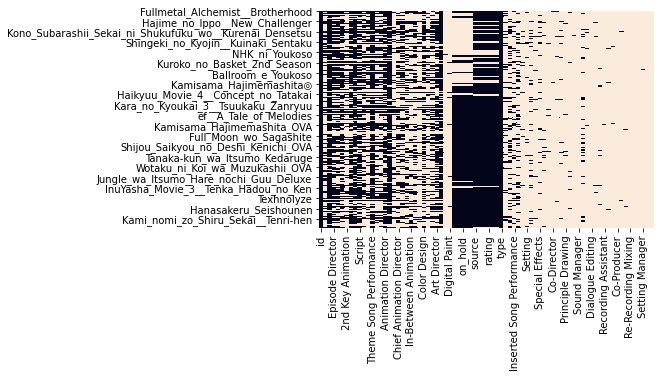

In [512]:
sns.heatmap(all_anime_detailed_info.isna(), cbar=False)

In [526]:
#percentage of data missing for each column
missing_series = (100*all_anime_detailed_info.isna().sum()/ all_anime_detailed_info.shape[0])
print(missing_series)
useless_columns = missing_series[missing_series.values>70].index
df_with_missing_data = all_anime_detailed_info.drop(useless_columns, axis=1)

In [531]:
(100*df_with_missing_data.isna().sum()/ df_with_missing_data.shape[0])

id                           0.000000
Producer                    65.996169
Director                    11.877395
Episode Director            41.858238
Storyboard                  35.344828
Sound Director              40.038314
Key Animation               28.639847
Character Design            22.030651
Script                      38.697318
Series Composition          55.172414
Theme Song Lyrics           61.685824
Theme Song Performance      18.869732
Theme Song Arrangement      65.708812
Theme Song Composition      59.099617
Animation Director          32.662835
Original Creator            15.421456
Chief Animation Director    57.375479
Director of Photography     57.375479
ADR Director                63.314176
Background Art              59.770115
Color Design                53.639847
Editing                     58.045977
Art Director                40.517241
Music                       19.157088
watching                    31.609195
completed                   31.609195
on_hold     

In [556]:
df_with_missing_data['rank']                                      

Fullmetal_Alchemist__Brotherhood                                                          1094
Shingeki_no_Kyojin_Season_3_Part_2                                                        1094
Steins_Gate                                                                               1094
Gintama°                                                                                  1094
Hunter_x_Hunter_2011                                                                      1094
                                                                                          ... 
Akage_no_Anne                                                                             1094
BanG_Dream_Film_Live                                                                      1094
Bishoujo_Senshi_Sailor_Moon_R                                                             1094
Boku_no_Hero_Academia_the_Movie_2__Heroes_Rising_-_Epilogue_Plus_-_Yume_wo_Genjitsu_ni    1094
Byousoku_5_Centimeter                             

In [561]:
#replacing missing Animation Director data with data from Chief Animation Director if data exists.
print(df_with_missing_data['Animation Director'].isna().sum())
df_with_missing_data['Animation Director'] = df_with_missing_data['Animation Director'].fillna(df_with_missing_data['Chief Animation Director'])

341


In [674]:
#only keeping some of the columns
df = df_with_missing_data[['id', 'Producer', 'Director', 'Character Design', 'Script', 'Music', 'type',
                           'Animation Director', 'Original Creator']]
df.head()

,id,Producer,Director,Character Design,Script,Music,type,Animation Director,Original Creator
Fullmetal_Alchemist__Brotherhood,5114,"Cook, Justin","Irie, Yasuhiro","Kanno, Hiroki","Tsuchiya, Michihiro","Senju, Akira",Movie,"Yoshioka, Takeshi","Arakawa, Hiromu"
Shingeki_no_Kyojin_Season_3_Part_2,38524,"Yabuta, Shuuhei","Koizuka, Masashi","Asano, Kyouji","Seko, Hiroshi","Sawano, Hiroyuki",Movie,"Yamashita, Megumi","Isayama, Hajime"
Steins_Gate,9253,"Yasuda, Takeshi","Satou, Takuya","Sakai, Kyuuta","Yokotani, Masahiro","Abo, Takeshi",Movie,"Yoshii, Hiroyuki",Nitroplus
Gintama°,28977,NaN,"Miyawaki, Chizuru","Takeuchi, Shinji","Mieno, Hitomi",Audio Highs,Movie,"Suzuki, Hiromi","Sorachi, Hideaki"
Hunter_x_Hunter_2011,11061,"Nakatani, Toshio","Koujina, Hiroshi","Yoshimatsu, Takahiro","Yonemura, Shouji","Mozart, Wolfgang Amadeus",Movie,"Yoshimatsu, Takahiro","Togashi, Yoshihiro"


In [675]:
for col in df.columns:
    df[col] = df[col].fillna(f'{col}_missing')
df

<ipython-input-675-26d6d464b422>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(f'{col}_missing')


,id,Producer,Director,Character Design,Script,Music,type,Animation Director,Original Creator
Fullmetal_Alchemist__Brotherhood,5114,"Cook, Justin","Irie, Yasuhiro","Kanno, Hiroki","Tsuchiya, Michihiro","Senju, Akira",Movie,"Yoshioka, Takeshi","Arakawa, Hiromu"
Shingeki_no_Kyojin_Season_3_Part_2,38524,"Yabuta, Shuuhei","Koizuka, Masashi","Asano, Kyouji","Seko, Hiroshi","Sawano, Hiroyuki",Movie,"Yamashita, Megumi","Isayama, Hajime"
Steins_Gate,9253,"Yasuda, Takeshi","Satou, Takuya","Sakai, Kyuuta","Yokotani, Masahiro","Abo, Takeshi",Movie,"Yoshii, Hiroyuki",Nitroplus
Gintama°,28977,Producer_missing,"Miyawaki, Chizuru","Takeuchi, Shinji","Mieno, Hitomi",Audio Highs,Movie,"Suzuki, Hiromi","Sorachi, Hideaki"
Hunter_x_Hunter_2011,11061,"Nakatani, Toshio","Koujina, Hiroshi","Yoshimatsu, Takahiro","Yonemura, Shouji","Mozart, Wolfgang Amadeus",Movie,"Yoshimatsu, Takahiro","Togashi, Yoshihiro"
...,...,...,...,...,...,...,...,...,...
Akage_no_Anne,283,Producer_missing,"Takahata, Isao","Kondou, Yoshifumi","Kouyama, Seijirou",Music_missing,Movie,"Kondou, Yoshifumi","Montgomery, Lucy Maud"
BanG_Dream_Film_Live,39619,Producer_missing,Director_missing,Character Design_missing,Script_missing,"Agematsu, Noriyasu",Movie,"Chanohara, Takuya","Nakamura, Kou"
Bishoujo_Senshi_Sailor_Moon_R,740,Producer_missing,"Satou, Junichi","Tadano, Kazuko","Yanagawa, Shigeru","Arisawa, Takanori",Movie,"Tamegai, Katsumi","Takeuchi, Naoko"
Boku_no_Hero_Academia_the_Movie_2__Heroes_Rising_-_Epilogue_Plus_-_Yume_wo_Genjitsu_ni,43683,Producer_missing,Director_missing,Character Design_missing,Script_missing,Music_missing,Movie,Animation Director_missing,Original Creator_missing


In [686]:
import re
def get_clean_title(df):
    clean_title = [re.sub('[!"#$%&\'()*+,-./:;<=>?@^_`{|}~]', ' ', title) for title in df.index]
    clean_title = [title.replace('  ', ' ') for title in clean_title]
    clean_title = [title.replace('  ', ' ') for title in clean_title]
    clean_title = [title.strip() for title in clean_title]
    return clean_title
df.index = get_clean_title(df)

In [708]:
df = df.drop('id', axis=1)

### one hot encoding the categorical columns

In [720]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(df)
transformed_feat = ohe.transform(df)
transformed_feat.shape

(1044, 2095)

In [710]:
#giving the name of the columns to ohe
ohe.get_feature_names(df.columns)

array(['Producer_Azuma, Fukashi', 'Producer_Campbell, Charles',
       'Producer_Choi, Eun-Young', ..., 'Original Creator_Yuuki, Masami',
       'Original Creator_Zen, Carlo', 'Original Creator_minori'],
      dtype=object)

In [770]:
#many of colums only have few non zero values, I'll remove the columns that have less than 3 non zero values in them 
feats = pd.DataFrame(transformed_feat, columns=ohe.get_feature_names(df.columns), index=df.index)
feats.sum().sort_values()[:20]

Producer_Azuma, Fukashi                  1.0
Animation Director_Sako, Souichirou      1.0
Script_Fletcher, Jack                    1.0
Animation Director_Sano, Keiichi         1.0
Script_Endou, Tetsuya                    1.0
Script_David, Alex Von                   1.0
Script_Choi, Eun-Young                   1.0
Script_Fujikawa, Keisuke                 1.0
Script_Chalopin, Jean                    1.0
Script_Buchholz, Bob                     1.0
Script_Bottom, Kyle                      1.0
Script_Aritomi, Kouji                    1.0
Script_Arihara, Seiji                    1.0
Script_Arias, Michael                    1.0
Script_Araki, Tetsurou                   1.0
Script_Cassell, Jalen K.                 1.0
Script_Araki, Kenichi                    1.0
Script_Fujisawa, Tsunekiyo               1.0
Script_Fukami, Makoto                    1.0
Animation Director_Oshiyama, Kiyotaka    1.0
dtype: float64

In [773]:
df_selected = feats[feats.sum()[feats.sum()>2].index.values]
df_selected

,"Producer_Choi, Eun-Young","Producer_Cook, Justin","Producer_Harp, Clarine","Producer_Hatta, Hideaki","Producer_Hatta, Youko","Producer_Higa, Yuuji","Producer_Horikawa, Kenji","Producer_Iwakami, Atsuhiro","Producer_Iwasa, Gaku","Producer_Kobayashi, Noriko",...,"Original Creator_Umino, Chika","Original Creator_Urobuchi, Gen","Original Creator_Urushibara, Yuki","Original Creator_Wakaki, Tamiki","Original Creator_Watari, Wataru","Original Creator_Watsuki, Nobuhiro","Original Creator_Yatate, Hajime","Original Creator_Yoshinaga, Yunosuke","Original Creator_Yoshinari, You","Original Creator_Yoshiura, Yasuhiro"
Fullmetal Alchemist Brotherhood,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shingeki no Kyojin Season 3 Part 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steins Gate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gintama°,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hunter x Hunter 2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Akage no Anne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BanG Dream Film Live,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bishoujo Senshi Sailor Moon R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Boku no Hero Academia the Movie 2 Heroes Rising Epilogue Plus Yume wo Genjitsu ni,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# getting anime synopsis using web-scraping 

In [54]:
current_link = 0
total_links = len(links)

In [57]:
cache_dir = 'cache_anime_info'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

@checkpoint(key=lambda args, kwargs: args[0].split('/')[-1], work_dir=cache_dir) 
@retry(wait_fixed = 5,stop_max_attempt_number=5)
def get_anime_page(link):
    global current_link, total_links
    print(f'\rTrying link {current_link} of {total_links}.', end='')
    session = FuturesSession(max_workers=1)
    page_response = session.get(link).result()
    if page_response.status_code != 200:
        print(f'\rFailed to get link: {link} ({page_response.status_code}). Retrying. {current_link} of {total_links} complete.', end='')
#         raise Exception(page_response.status_code)
    current_link = current_link + 1
    return page_response

In [310]:
anime_page = [get_anime_page(link) for link in links]

In [300]:
all_pages_response = []
for filename in glob.glob('cache_anime_info/**/*', recursive=True):    
    with open(filename, 'rb') as f:
        all_pages_response.append(dill.load(f))

In [2]:
#sample response 
# all_pages_response[0]

In [426]:
#getting synopsis for an anime 
def get_anime_synopsis(page_response):
    anime_synopsis = defaultdict(str)
    soup = BeautifulSoup(page_response.text)
    title = soup.find('h1', class_='title-name').text
    synopsis = soup.find('p', attrs={'itemprop': 'description'}).get_text(strip=True)
    anime_synopsis[title] = synopsis
    return anime_synopsis

In [427]:
#getting  synopsis for all anime 
all_anime_synopsis = defaultdict(str)
for page_response in all_pages_response:
    all_anime_synopsis.update(get_anime_synopsis(page_response))

In [688]:
df_synopsis = pd.DataFrame(all_anime_synopsis.items(), columns =['title', 'synopsis'])
df_synopsis.head()

,title,synopsis
0,Ashita no Joe,"Joe Yabuki is a troubled youth, whose only sol..."
1,Densetsu Kyojin Ideon: Hatsudou-hen,"Pushed out to the far reaches of the galaxy, t..."
2,Genshiken 2,The Society for the Study of Modern Visual Cul...
3,Junjou Romantica 2,The second part ofJunjou Romanticacontinuing t...
4,One Piece,"Gol D. Roger was known as the ""Pirate King,"" t..."


In [689]:
df_synopsis.set_index('title', inplace=True)
df_synopsis.index = get_clean_title(df_synopsis)

# Using Spacy to get stop words and for lemmatization

In [4]:
from spacy.lang.en.stop_words import STOP_WORDS
import string 
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = spacy.load('en')

In [439]:
#lemmatization, replacing words by their common root
def get_lemma(row):
    trial = [word.lemma_.lower() for word in nlp(row) if word.text not in string.punctuation]
    return trial 
# df_synopsis['synopsis'] = df_synopsis['synopsis'].apply(get_lemma)

In [440]:
df_synopsis.head()

,synopsis
title,
Ashita no Joe,joe yabuki be a troubled youth whose only solu...
Densetsu Kyojin Ideon: Hatsudou-hen,push out to the far reach of the galaxy the cr...
Genshiken 2,the society for the study of modern visual cul...
Junjou Romantica 2,the second part ofjunjou romanticacontinue the...
One Piece,gol d. roger be know as the pirate king the st...


In [441]:
#lemmatizing the stopwords 
STOP_WORDS = STOP_WORDS.union(['ll', 've', 'to', 'ago', 'all', 'as', 'at', 'be', 'but', 'by', 'or'])
stop_words_lemma = set(get_lemma(' '.join(STOP_WORDS)))

# Term frequency–inverse document frequency (TF-IDF)

In [775]:
tfidf = TfidfVectorizer(stop_words= stop_words_lemma,
                        lowercase=True,
                        tokenizer=get_lemma,
                        max_df=0.9,
                        min_df=0.01,
                        max_features=500, 
                        token_pattern = None)
tfidf = tfidf.fit(df_synopsis['synopsis'])
tfidf_matrix = tfidf.transform(df_synopsis['synopsis'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=df_synopsis.index)
tfidf.get_feature_names()

['...',
 'abandon',
 'ability',
 'able',
 'academy',
 'accept',
 'achieve',
 'act',
 'action',
 'adventure',
 'age',
 'agree',
 'aid',
 'aim',
 'alien',
 'alliance',
 'allow',
 'ally',
 'alongside',
 'anime',
 'ann',
 'apartment',
 'appear',
 'appearance',
 'approach',
 'araragi',
 'arm',
 'arrival',
 'arrive',
 'art',
 'ask',
 'attack',
 'attempt',
 'attend',
 'await',
 'away',
 'bad',
 'band',
 'baseball',
 'battle',
 'bear',
 'beautiful',
 'befriend',
 'begin',
 'being',
 'believe',
 'big',
 'black',
 'body',
 'book',
 'boy',
 'break',
 'bring',
 'brother',
 'capture',
 'case',
 'cat',
 'catch',
 'cause',
 'challenge',
 'chance',
 'change',
 'character',
 'chase',
 'child',
 'childhood',
 'choice',
 'choose',
 'city',
 'claim',
 'clan',
 'class',
 'classmate',
 'close',
 'cloud',
 'club',
 'college',
 'come',
 'companion',
 'company',
 'competition',
 'complete',
 'completely',
 'conan',
 'conflict',
 'confront',
 'constantly',
 'continue',
 'control',
 'council',
 'country',
 'crea

### merging two dfs

In [778]:
merged_df = pd.merge(df_selected, tfidf_df, right_index=True, left_index=True)
merged_df.head()

,"Producer_Choi, Eun-Young","Producer_Cook, Justin","Producer_Harp, Clarine","Producer_Hatta, Hideaki","Producer_Hatta, Youko","Producer_Higa, Yuuji","Producer_Horikawa, Kenji","Producer_Iwakami, Atsuhiro","Producer_Iwasa, Gaku","Producer_Kobayashi, Noriko",...,490,491,492,493,494,495,496,497,498,499
3 gatsu no Lion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.098161,0.000000,0.000000,0.000000,0.0
3 gatsu no Lion 2nd Season,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.089030,0.088568,0.000000,0.156358,0.0
5 toubun no Hanayome ∬,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.107133,0.0
86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.107700,0.000000,0.125338,0.094573,0.0
91 Days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.214016,0.0,0.0,0.0,0.000000,0.111726,0.130703,0.000000,0.0


# measuring similarity between anime, cosine similarity

In [780]:
anime_cosine_similarity = cosine_similarity(merged_df,merged_df)
anime_cosine_similarity_df = pd.DataFrame(anime_cosine_similarity, columns=merged_df.index, index= merged_df.index)
anime_cosine_similarity_df.head()

,3 gatsu no Lion,3 gatsu no Lion 2nd Season,5 toubun no Hanayome ∬,86,91 Days,Aggressive Retsuko ONA 2nd Season,Aggressive Retsuko ONA 3rd Season,Akachan to Boku,Akagami no Shirayuki hime,Akagami no Shirayuki hime 2nd Season,...,Zoku Owarimonogatari,Zoku Sayonara Zetsubou Sensei,Zombieland Saga Revenge,ef A Tale of Melodies,ef A Tale of Memories,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
3 gatsu no Lion,1.000000,0.783445,0.550437,0.321334,0.258644,0.383084,0.360880,0.265735,0.248330,0.244992,...,0.370955,0.261575,0.400892,0.301111,0.305238,0.121180,0.138225,0.149357,0.366860,0.364330
3 gatsu no Lion 2nd Season,0.783445,1.000000,0.579232,0.326403,0.259057,0.515319,0.494327,0.256289,0.249948,0.242174,...,0.366597,0.257035,0.413236,0.161828,0.170133,0.125887,0.124154,0.141673,0.362345,0.354240
5 toubun no Hanayome ∬,0.550437,0.579232,1.000000,0.464726,0.370343,0.537857,0.521164,0.357604,0.343979,0.346686,...,0.344955,0.188364,0.566947,0.240477,0.245006,0.181204,0.169238,0.200461,0.505619,0.501331
86,0.321334,0.326403,0.464726,1.000000,0.169993,0.321595,0.302937,0.166853,0.153531,0.153087,...,0.155507,0.159824,0.338062,0.190991,0.190583,0.156943,0.159678,0.178871,0.307212,0.309687
91 Days,0.258644,0.259057,0.370343,0.169993,1.000000,0.382865,0.362910,0.266853,0.241919,0.254595,...,0.128575,0.125000,0.400892,0.164343,0.154198,0.124064,0.118543,0.154939,0.250069,0.239379


# Returning the top 10 anime similar to a given anime by user

In [782]:
def recommended_anime(given_anime):
    return anime_cosine_similarity_df[given_anime].sort_values(ascending=False)[1:11].index.values

print('type in the title of movie you like')
given_anime = input()
recommended_anime('One Piece')

type in the title of movie you like
One Piece


array(['Shigatsu wa Kimi no Uso', 'Detective Conan',
       'Neon Genesis Evangelion', 'Kenpuu Denki Berserk',
       'One Piece Movie 14 Stampede', 'Shingeki no Kyojin Season 2',
       'Fullmetal Alchemist',
       'One Piece Episode of Nami Koukaishi no Namida to Nakama no Kizuna',
       'Nodame Cantabile', 'One Piece Film Z'], dtype=object)